# Flight Data Analysis
We have dataset contains information about all flights that departed from NYC in 2013, Contains around 336,776 total flights.



### This dataset is composed by the following variables:

1.	**year**            2013
2.	**month**           1-12
3.	**day**				Day of month(1-31)
4.	**dep_time**		Departure times, local timezone
5.	**sched_dep_time**	Scheduled departure time
6.	**dep_delay**		Departure delay, in minutes, Negative times represent early departures
7.	**arr_time**		Arrival times, local timezone
8.	**sched_arr_time**	Scheduled arrival time
9.	**arr_delay**		Arrival delay, in minutes, Negative times represent early arrivals
10.	**carrier**			Two letter carrier abbreviation
11.	**flight**			Flight number
12.	**tailnum**			Plane tail number
13.	**origin**			Airport codes for origin
14.	**dest**			Airport codes for destination
15.	**air_time**		Amount of time spent in the air, in minutes
16.	**distance**		Distance flown, in miles
17.	**hour**			Time of departure broken in to hour
18.	**minute**			Time of departure broken in to minutes
19.	**time_hour**		Timestamp


In [83]:
#Load dependencies
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

## 1. Loading the data

The first step is to load the data we're working with into a pandas DatFrame.



In [84]:
#loading and showing head data
df = pd.read_csv('flight_data.csv', na_values=['NA'])
df.head(5)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,01-01-2013 05:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,01-01-2013 05:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,01-01-2013 05:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,01-01-2013 05:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,01-01-2013 06:00


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          328521 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         328521 non-null float64
arr_time          328063 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         327346 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
tailnum           334264 non-null object
origin            336776 non-null object
dest              336776 non-null object
air_time          327346 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
dtypes: float64(5), int64(9), object(5)
memory usage: 48.8+ MB


## 2. Understanding and cleaning the data

The flight data contains some missing and wrong-formatted data which has to be cleaned up first.<br><br>Generally, we're looking to answer the following questions:<br>
**Is there anything wrong with the data?**<br>
**Are there any quirks with the data?**<br>
**Do we need to fix or remove any of the data?**<br><br>

In [86]:

#Cleaning and formatting time columns
df['dep_time'] = df.dep_time[~df.dep_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['dep_time'] = pd.to_timedelta(df.dep_time.str[:2]+':'+df.dep_time.str[2:]+':00')

df['sched_dep_time'] = df.sched_dep_time[~df.sched_dep_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['sched_dep_time'] = pd.to_timedelta(df.sched_dep_time.str[:2]+':'+df.sched_dep_time.str[2:]+':00')

df['arr_time'] = df.arr_time[~df.arr_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['arr_time'] = pd.to_timedelta(df.arr_time.str[:2]+':'+df.arr_time.str[2:]+':00')

df['sched_arr_time'] = df.sched_arr_time[~df.sched_arr_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['sched_arr_time'] = pd.to_timedelta(df.sched_arr_time.str[:2]+':'+df.sched_arr_time.str[2:]+':00')

df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']] = df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']].apply(lambda x: pd.to_timedelta(x))

#We have 458 flights where flight dep_time is present but arr_time, arr_delay and air_time is missing, 
#So we can replace arr_time and arr_delay 

#Add minutes
def addMinutes(time, mins):
    return (pd.to_timedelta(time) + pd.Timedelta(minutes=mins))

#Replace arr_time with sched_arr_time + dep_delay
mask = (~df.dep_time.isna() & df.arr_time.isna())
df.loc[mask, "arr_time"] = df[mask].apply(lambda row: addMinutes(row['sched_arr_time'], row['dep_delay']), axis=1)

#Using proper data types
#df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']] = df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']].apply(lambda x: pd.to_timedelta(x))

#Replace arr_delay with arr_time - sched_arr_time
arr_delay_mask = (df.arr_time.notna() & df.arr_delay.isna())
df.loc[arr_delay_mask, "arr_delay"] = ((df.loc[arr_delay_mask, "arr_time"] - df.loc[arr_delay_mask, "sched_arr_time"]).astype('timedelta64[s]')//60)

#Arrival delay threshold is -100 mins
arr_delay_thresh_mask = (df.arr_delay.notna() & (df.arr_delay < -100))
df.loc[arr_delay_thresh_mask, "arr_delay"] = (1440 + df.loc[arr_delay_thresh_mask, "arr_delay"])

#Replace add missing air_time
air_time_mask = (df.dep_time.notna() & df.arr_time.notna() & df.air_time.isna())
df.loc[air_time_mask, "air_time"] = abs((df.loc[air_time_mask, "arr_time"] - df.loc[air_time_mask, "dep_time"]).astype('timedelta64[s]')//60)


# Create two columns with Ontime, Late and Cancelled status for both departure and arrival
df.loc[df.dep_delay.isna(), "dep_status"]="Canceled"
df.loc[df.dep_delay <= 0, "dep_status"]="OnTime"
df.loc[df.dep_delay > 0, "dep_status"]="Late"
df.loc[df.arr_delay.isna(), "arr_status"]="Canceled"
df.loc[df.arr_delay <= 0, "arr_status"]="OnTime"
df.loc[df.arr_delay > 0, "arr_status"]="Late"

#Dropping unwanted columns
df.drop("year", 1, inplace=True)
df.drop("hour", 1, inplace=True)
df.drop("minute", 1, inplace=True)
df.drop("tailnum", 1, inplace=True)
df.drop("time_hour", 1, inplace=True)

#Using proper data types 
df[['month','day', 'carrier', 'origin', 'dest', 'dep_status', 'arr_status']] = df[['month','day', 'carrier', 'origin', 'dest', 'dep_status', 'arr_status']].apply(lambda x: x.astype('category'))


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 16 columns):
month             336776 non-null category
day               336776 non-null category
dep_time          328521 non-null timedelta64[ns]
sched_dep_time    336776 non-null timedelta64[ns]
dep_delay         328521 non-null float64
arr_time          328521 non-null timedelta64[ns]
sched_arr_time    336776 non-null timedelta64[ns]
arr_delay         328521 non-null float64
carrier           336776 non-null category
flight            336776 non-null int64
origin            336776 non-null category
dest              336776 non-null category
air_time          328521 non-null float64
distance          336776 non-null int64
dep_status        336776 non-null category
arr_status        336776 non-null category
dtypes: category(7), float64(3), int64(2), timedelta64[ns](4)
memory usage: 25.4 MB


In [88]:
df.head(10)

,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,origin,dest,air_time,distance,dep_status,arr_status
0,1,1,05:17:00,05:15:00,2.0,08:30:00,08:19:00,11.0,UA,1545,EWR,IAH,227.0,1400,Late,Late
1,1,1,05:33:00,05:29:00,4.0,08:50:00,08:30:00,20.0,UA,1714,LGA,IAH,227.0,1416,Late,Late
2,1,1,05:42:00,05:40:00,2.0,09:23:00,08:50:00,33.0,AA,1141,JFK,MIA,160.0,1089,Late,Late
3,1,1,05:44:00,05:45:00,-1.0,10:04:00,10:22:00,-18.0,B6,725,JFK,BQN,183.0,1576,OnTime,OnTime
4,1,1,05:54:00,06:00:00,-6.0,08:12:00,08:37:00,-25.0,DL,461,LGA,ATL,116.0,762,OnTime,OnTime
5,1,1,05:54:00,05:58:00,-4.0,07:40:00,07:28:00,12.0,UA,1696,EWR,ORD,150.0,719,OnTime,Late
6,1,1,05:55:00,06:00:00,-5.0,09:13:00,08:54:00,19.0,B6,507,EWR,FLL,158.0,1065,OnTime,Late
7,1,1,05:57:00,06:00:00,-3.0,07:09:00,07:23:00,-14.0,EV,5708,LGA,IAD,53.0,229,OnTime,OnTime
8,1,1,05:57:00,06:00:00,-3.0,08:38:00,08:46:00,-8.0,B6,79,JFK,MCO,140.0,944,OnTime,OnTime
9,1,1,05:58:00,06:00:00,-2.0,07:53:00,07:45:00,8.0,AA,301,LGA,ORD,138.0,733,OnTime,Late


## 3. Pandas Profiling

Generates profile reports from a pandas DataFrame.<br><br>For each column the following statistics - if relevant for the column type - are presented in an interactive HTML report:<br>
**Essentials:** type, unique values, missing values <br>
**Quantile statistics:** like minimum value, Q1, median, Q3, maximum, range, interquartile range <br>
**Descriptive statistics:** like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness <br>
**Correlations:** highlighting of highly correlated variables, Spearman and Pearson matrixes <br>
**Most frequent values** <br>
**Histogram**<br><br>

In [89]:
#Generate profile reports
profileReport = pdp.ProfileReport(df)
#Import profile report
profileReport.to_file(outputfile="profile.html")

In [91]:
profileReport

Number of variables,16
Number of observations,336776
Total Missing (%),0.6%
Total size in memory,25.4 MiB
Average record size in memory,79.0 B
Numeric,3
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,2


## 4. Distribution of data

it's always a good idea to look at the distribution of our data — especially the outliers.<br>
Let's start by printing out some summary statistics about the data set.<br><br>

In [92]:
df.describe()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance
count,328521,336776,328521.000000,328521,336776,328521.000000,336776.000000,328521.000000,336776.000000
mean,0 days 13:42:10.090131,0 days 13:37:02.696629,12.639070,0 days 15:13:12.569607,0 days 15:33:26.591621,7.329635,1971.923620,151.225736,1039.912604
std,0 days 04:52:43.859391,0 days 04:41:08.833305,40.210061,0 days 05:20:10.560649,0 days 04:58:58.522489,45.591673,1632.471938,95.297581,733.233033
min,0 days 00:01:00,0 days 01:06:00,-43.000000,0 days 00:01:00,0 days 00:01:00,-86.000000,1.000000,20.000000,17.000000
25%,0 days 09:07:00,0 days 09:06:00,-5.000000,0 days 11:05:00,0 days 11:24:00,-17.000000,553.000000,82.000000,502.000000
50%,0 days 14:01:00,0 days 13:59:00,-2.000000,0 days 15:36:00,0 days 15:56:00,-5.000000,1496.000000,130.000000,872.000000
75%,0 days 17:44:00,0 days 17:29:00,11.000000,0 days 19:41:00,0 days 19:45:00,14.000000,3465.000000,192.000000,1389.000000
max,1 days 00:00:00,0 days 23:59:00,1301.000000,1 days 02:29:00,0 days 23:59:00,1272.000000,8500.000000,1289.000000,4983.000000


### Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will use the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows


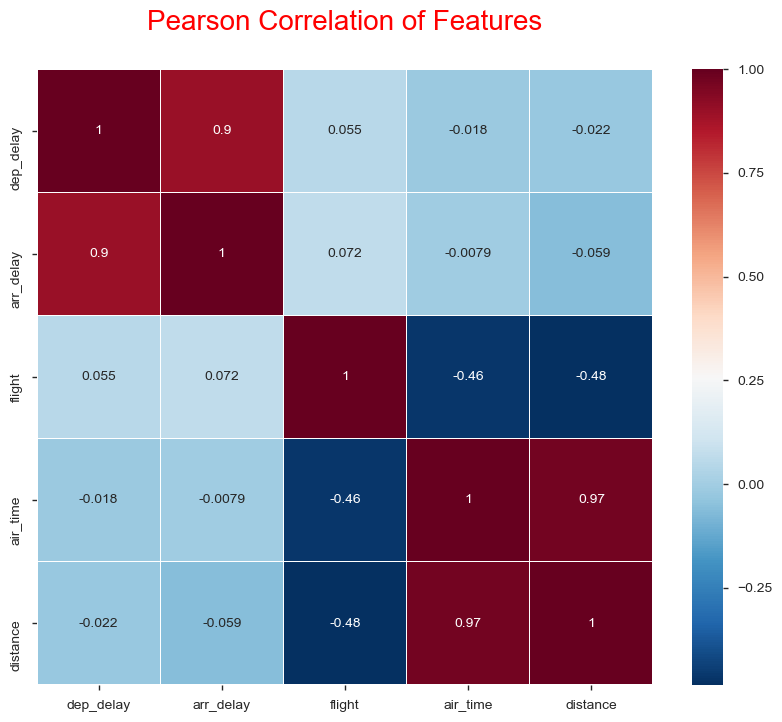

In [95]:
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', y=1.05, size=20, color='R')
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu_r, linecolor='white', annot=True)
plt.show()

In [8]:
df1 = df
temp = df

<br>
## 5. Exploratory data analysis

<br>Data cleaning step is completed now we can start analyzing the data.<br>Exploratory analysis is the step where we start delving deeper into the data set beyond the outliers and errors. This is the stage where we plot all the data in as many ways as possible.<br><br>
# 5.1 Flights Frequency
## 5.1.1 Busiest airport in terms of flights departure

In [96]:
buzAir = df.groupby(['origin'])['origin'].count()
buzAir

origin
EWR    120835
JFK    111279
LGA    104662
Name: origin, dtype: int64

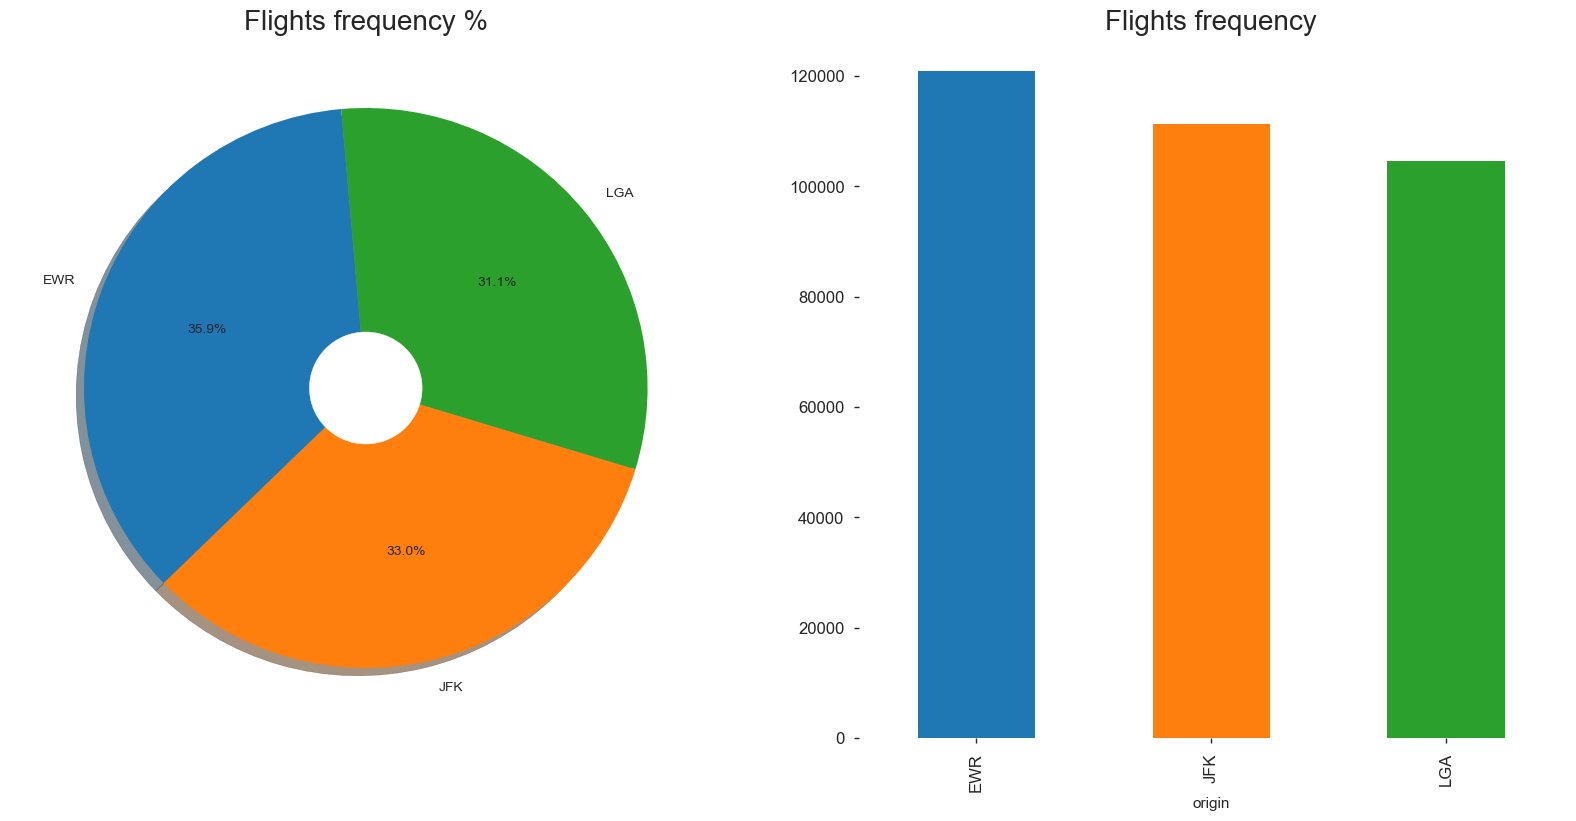

In [106]:
fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(221)
ax.pie(buzAir, labeldistance=1.1, labels=buzAir.index, startangle=95, autopct='%1.1f%%', shadow=True)
ax.set_title("Flights frequency %", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.set_title("Flights frequency", fontsize=20);
ax2.set_facecolor('white')
buzAir.plot(kind='bar', ax=ax2,  legend=False, fontsize=12)
plt.show()

### EWR is the busiest airport with 35.9% of total flights departed from this airport, followed by JFK(33%) and LGA(31.1%)<br><br> 

## 5.1.2 Flights frequency across months

In [107]:
buzMonth = df.groupby(['month'])['month'].count()
buzMonth

month
1     27004
2     24951
3     28834
4     28330
5     28796
6     28243
7     29425
8     29327
9     27574
10    28889
11    27268
12    28135
Name: month, dtype: int64

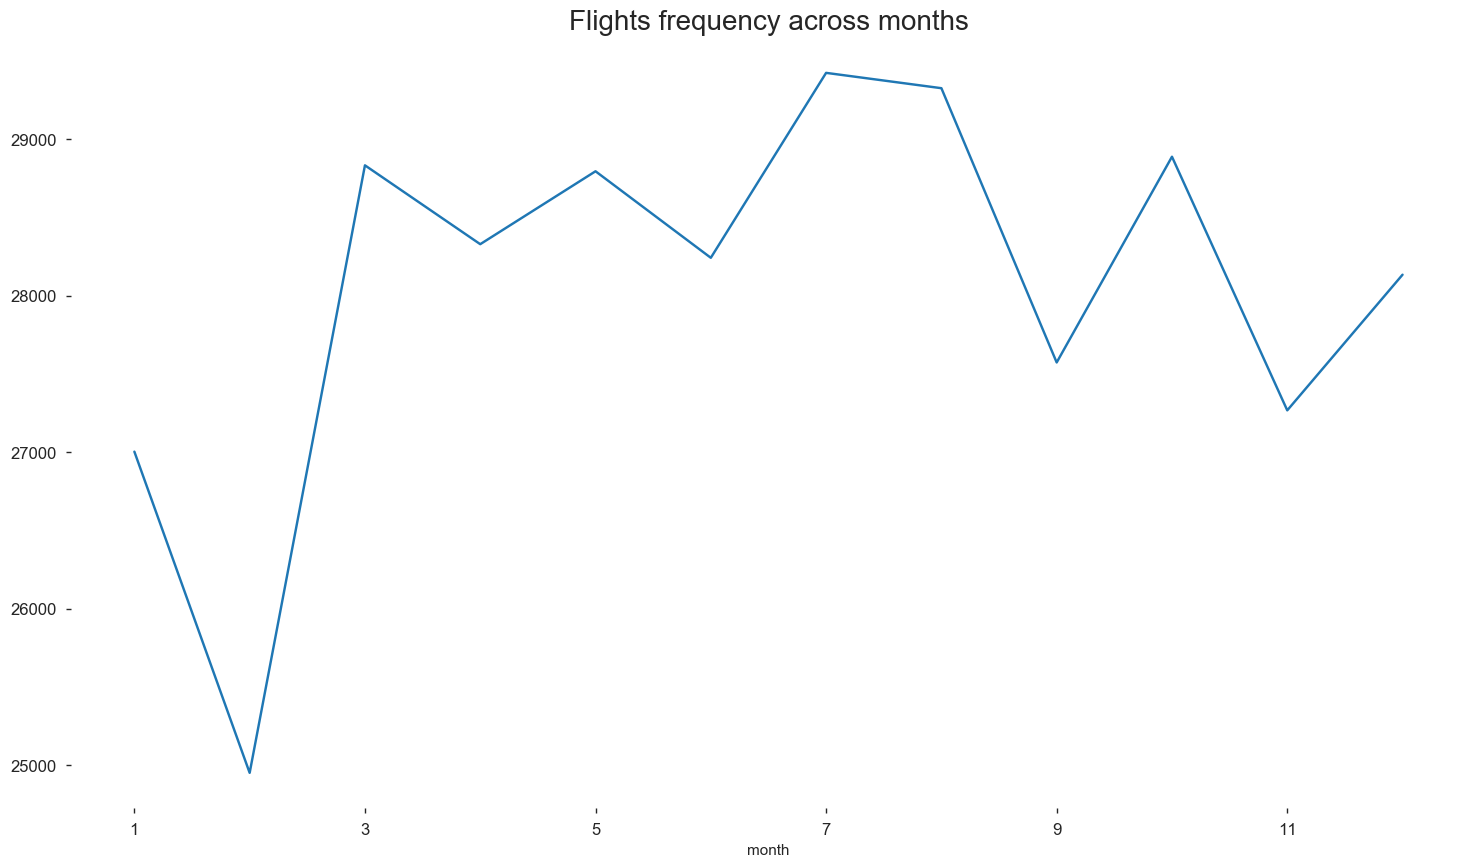

In [111]:
fig = plt.figure(figsize=[18, 10])
ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.set_title("Flights frequency across months", fontsize=20);
buzMonth.plot(ax=ax,  legend=False, fontsize=12)
plt.show()

### Flights frequency is lowest in February which is below 25000.<br><br> 

# 5.2 Departure and Arrival status

In [112]:
depStatus = df.groupby('dep_status')['dep_status'].count()
arrStatus = df.groupby('arr_status')['arr_status'].count()
print(depStatus)
print()
print(arrStatus)

dep_status
Canceled      8255
Late        128432
OnTime      200089
Name: dep_status, dtype: int64

arr_status
Canceled      8255
Late        134032
OnTime      194489
Name: arr_status, dtype: int64


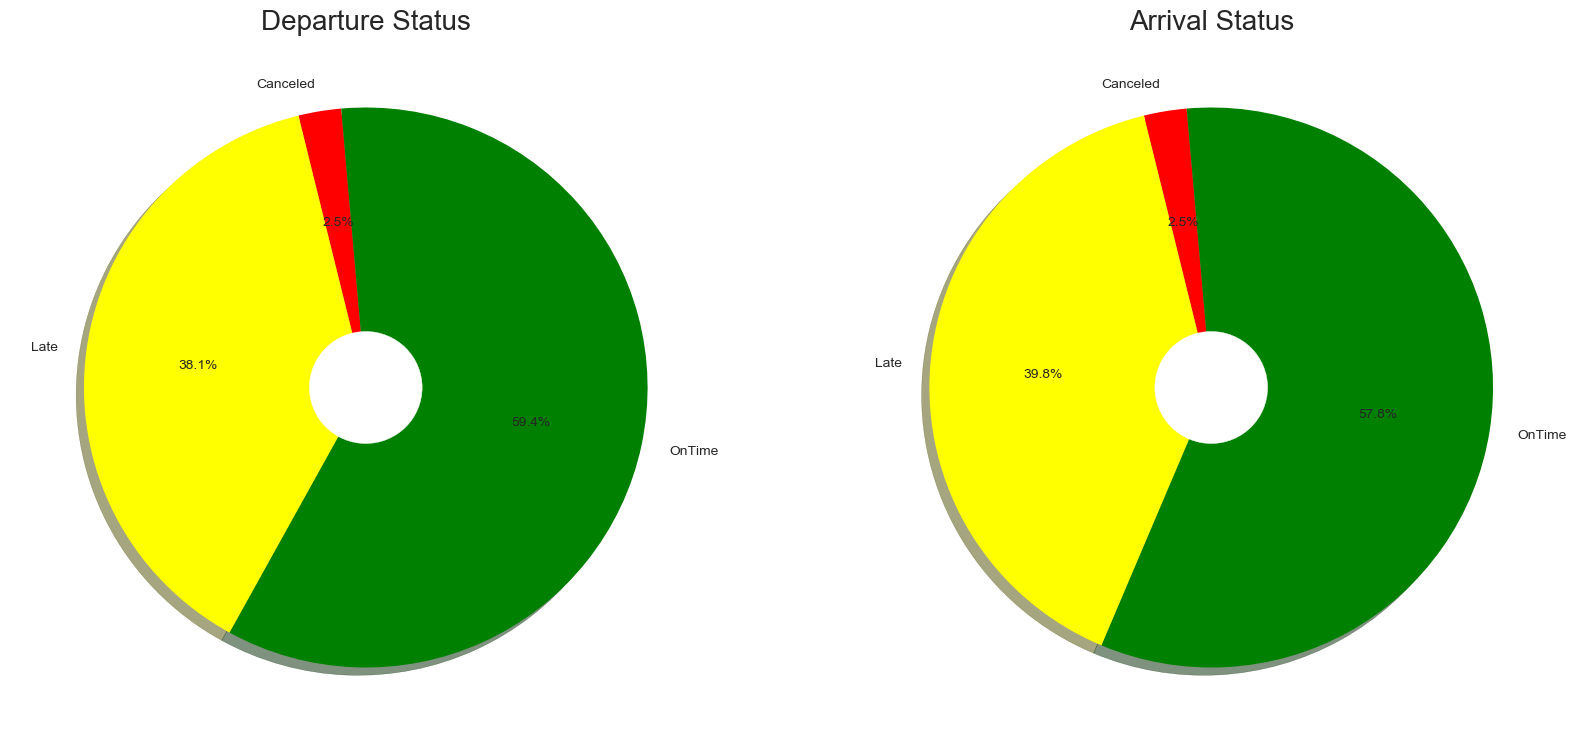

In [113]:
fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(221)
ax.pie(depStatus, labeldistance=1.1, labels=depStatus.index, startangle=95, autopct='%1.1f%%', shadow=True, colors=['red','yellow','green'])
ax.set_title("Departure Status", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.pie(arrStatus, labeldistance=1.1, labels=arrStatus.index, startangle=95, autopct='%1.1f%%', shadow=True, colors=['red','yellow','green'])
ax2.set_title("Arrival Status", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))
plt.show()

### Out of 336776 flights,  200089(59.1%) flights in 2013 were departed on time, 128432(38.1%) were delayed and just 8255(2.5%) of flights were canceled.<br><br>

# 5.3 Delayed Flights

## 5.3.1 Best and worst airport in terms of departure and arrival delay

In [114]:
depAir = df.loc[df['dep_status'] == 'Late'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
depAir

dep_status,Late
origin,
EWR,52711.0
JFK,42031.0
LGA,33690.0


In [115]:
arrAir = df.loc[df['arr_status'] == 'Late'].groupby(['origin','arr_status'])['arr_status'].count().unstack('arr_status')
arrAir

arr_status,Late
origin,
EWR,50531.0
JFK,43182.0
LGA,40319.0


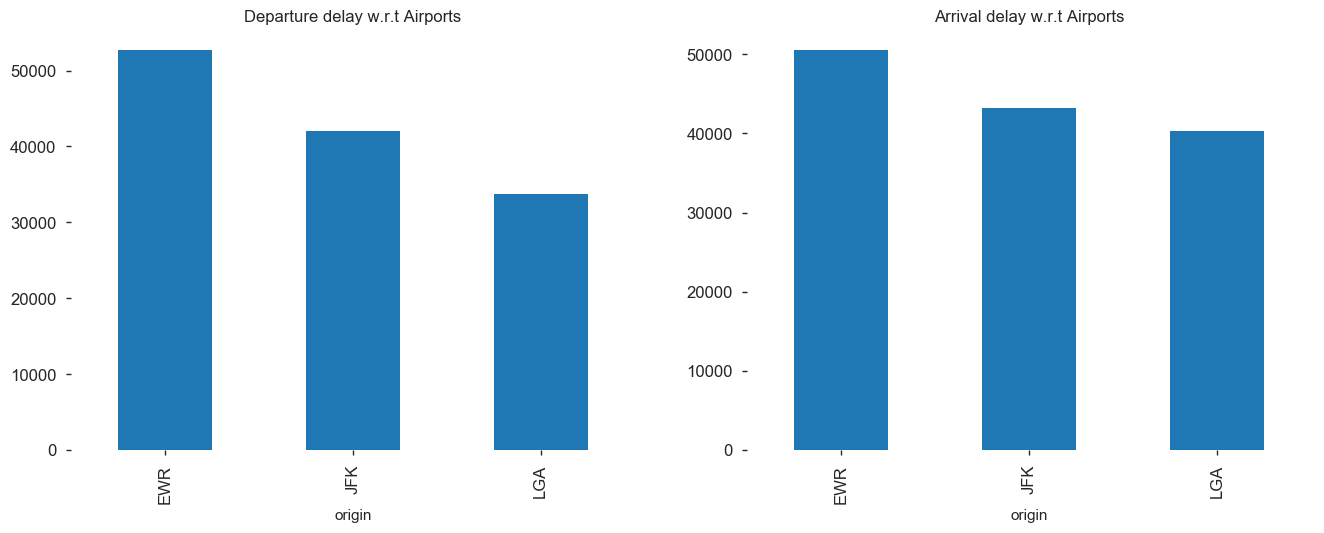

In [122]:
fig = plt.figure(figsize=[16, 12])
ax = fig.add_subplot(221)
depAir.plot(kind='bar', ax=ax, title ="Departure delay w.r.t Airports",  legend=False, fontsize=12)
ax2 = fig.add_subplot(222)
ax.set_facecolor('white')
ax2.set_facecolor('white')
arrAir.plot(kind='bar', ax=ax2, title ="Arrival delay w.r.t Airports",  legend=False, fontsize=12)
plt.show()

### LGA airport is best in terms of departure and arrival delay, where as EWR is worst with 5000+ delayed flights. <br><br>

## 5.3.2 Best and worst airport w.r.t departure delay %

In [123]:
depAirPer = df.groupby('origin')['origin'].count().reset_index(name='total')
delayedFlights = df.loc[df['dep_status'] == 'Late'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
depAirPer['late'] = delayedFlights['Late'].values
depAirPer['percentage'] = (depAirPer['late']/depAirPer['total'])*100
depAirPer.set_index('origin', inplace=True)
depAirPer

,total,late,percentage
origin,,,
EWR,120835,52711.0,43.622295
JFK,111279,42031.0,37.770828
LGA,104662,33690.0,32.189333


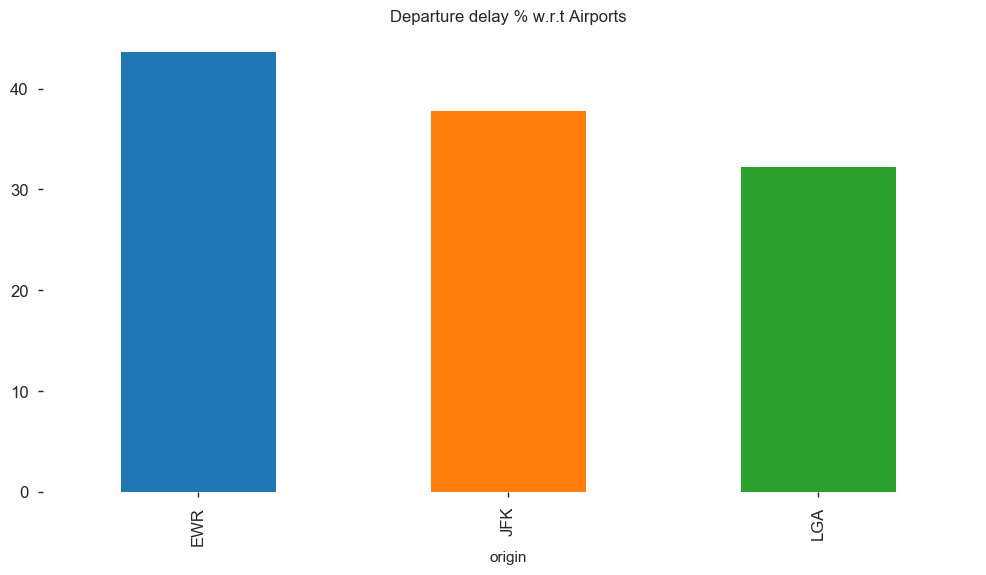

In [140]:
depAirPer['percentage'].plot(kind='bar', figsize=[12,6], title ="Departure delay % w.r.t Airports",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

### 43% of total flight departed from EWR were delayed, which is highest among all.<br><br>

## 5.3.3 Best and worst carrier in terms of departure delay %

In [141]:
depCarrier = df1.loc[df1['dep_status'] == 'Late'].groupby(['carrier','dep_status'])['dep_status'].count().unstack('dep_status')
depCarrier

dep_status,Late
carrier,
9E,7063.0
AA,10162.0
AS,226.0
B6,21445.0
DL,15241.0
EV,23139.0
F9,341.0
FL,1654.0
HA,69.0


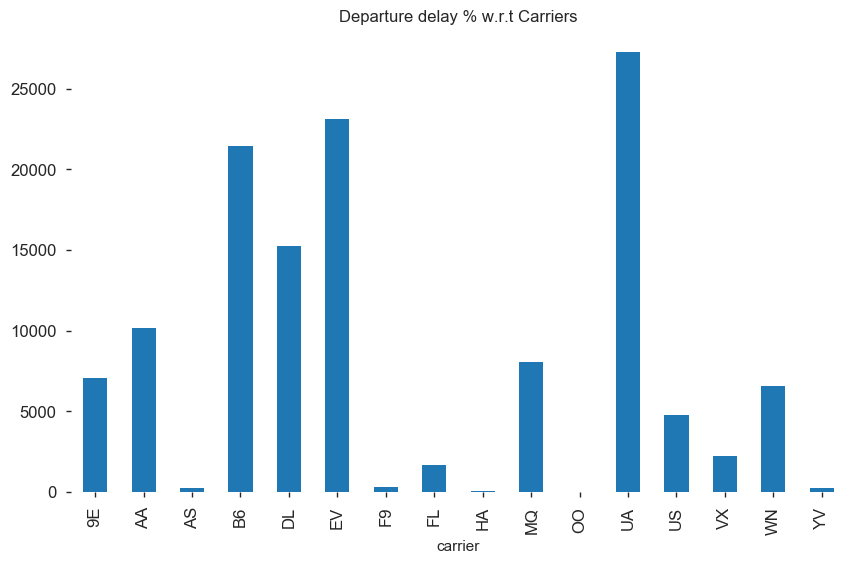

In [144]:
depCarrier.plot(kind='bar', figsize=[10,6], title ="Departure delay % w.r.t Carriers",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [146]:
depCarrierPer = df1.groupby('carrier')['carrier'].count().reset_index(name='total')
delayedFlights = df1.loc[df1['dep_status'] == 'Late'].groupby(['carrier','dep_status'])['dep_status'].count().unstack('dep_status')
depCarrierPer['late'] = delayedFlights['Late'].values
depCarrierPer['percentage'] = (depCarrierPer['late']/depCarrierPer['total'])*100
depCarrierPer.set_index('carrier', inplace=True)
depCarrierPer

,total,late,percentage
carrier,,,
9E,18460,7063.0,38.261105
AA,32729,10162.0,31.048917
AS,714,226.0,31.652661
B6,54635,21445.0,39.251396
DL,48110,15241.0,31.679485
EV,54173,23139.0,42.713160
F9,685,341.0,49.781022
FL,3260,1654.0,50.736196
HA,342,69.0,20.175439


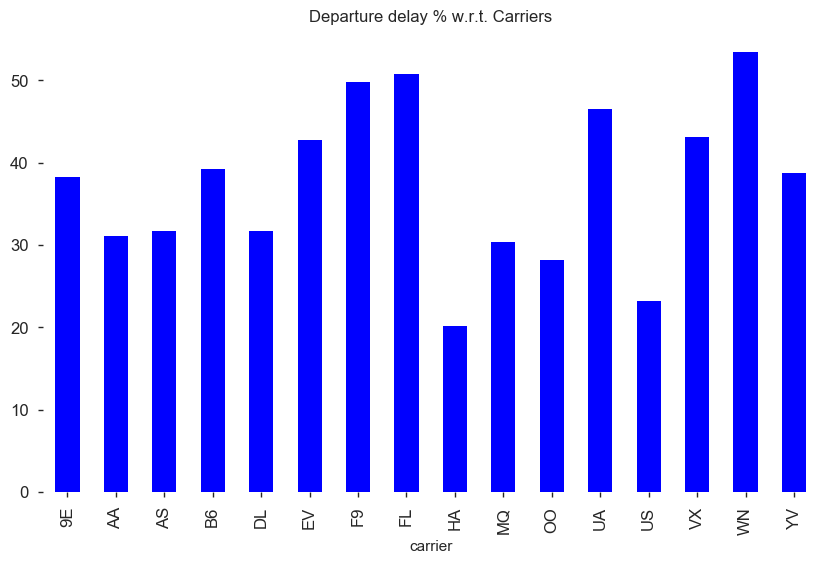

In [153]:
depCarrierPer[['percentage']].plot(kind='bar', figsize=[10,6], title ="Departure delay % w.r.t. Carriers",  legend=False, fontsize=12, color='blue')
plt.gca().set_facecolor('white')
plt.show()

### HA carrier is best in terms of departure delay with just 20% of total flight got delayed, On other hand WN performed worst with 53% of delayed flights followed by FL and F9.<br><br>

## 5.3.4 Departure delay across months

In [151]:
depMonth = df1.loc[df1['dep_status'] == 'Late'].groupby(['month','dep_status'])['dep_status'].count().unstack('dep_status')
depMonth

dep_status,Late
month,
1,9662.0
2,9124.0
3,11209.0
4,10543.0
5,11291.0
6,12655.0
7,13909.0
8,11713.0
9,7815.0


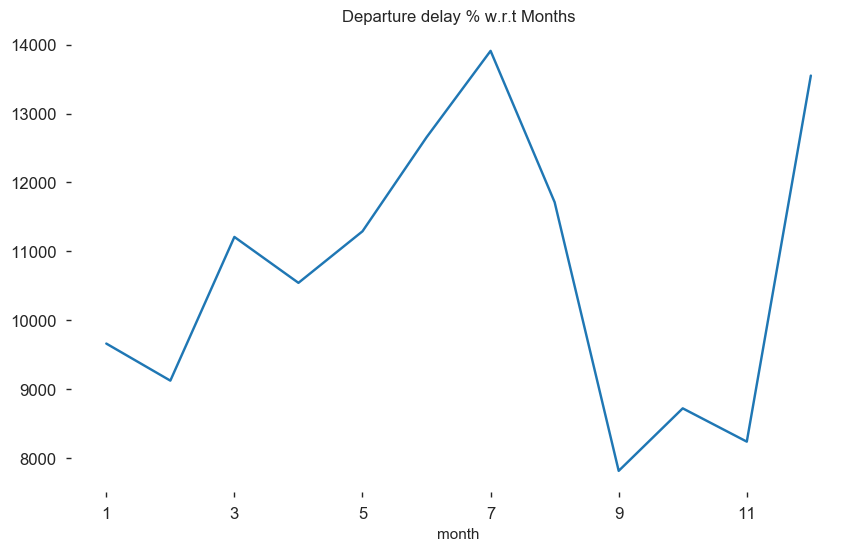

In [157]:
depMonth.plot(figsize=[10,6], title ="Departure delay % w.r.t Months",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

### As we can see from the above graph, flights delay is more in June, July and December months, where as September is best month to travel.

# 5.4 Canceled Flights

## 5.4.1 Best and worst airport in terms of number of flights canceled

In [158]:
canAir = df.loc[df['dep_status'] == 'Canceled'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
canAir

dep_status,Canceled
origin,
EWR,3239.0
JFK,1863.0
LGA,3153.0


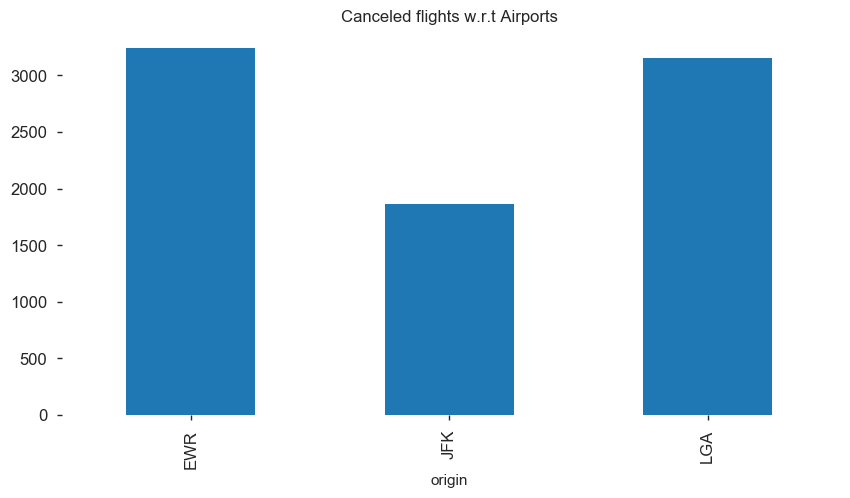

In [162]:
canAir.plot(kind='bar', figsize=[10,5], title ="Canceled flights w.r.t Airports",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

### 1863 flights got canceled from JFK airport in 2013, which is lowest among all.<br><br>

## 5.4.2 Best and worst airport w.r.t flight cancellation %

In [165]:
canAirPer = df.groupby('origin')['origin'].count().reset_index(name='total')
canceledFlights = df1.loc[df1['dep_status'] == 'Canceled'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
canAirPer['canceled'] = canceledFlights['Canceled'].values
canAirPer['percentage'] = (canAirPer['canceled']/canAirPer['total'])*100
canAirPer.set_index('origin', inplace=True)
canAirPer

,total,canceled,percentage
origin,,,
EWR,120835,3239.0,2.680515
JFK,111279,1863.0,1.674170
LGA,104662,3153.0,3.012555


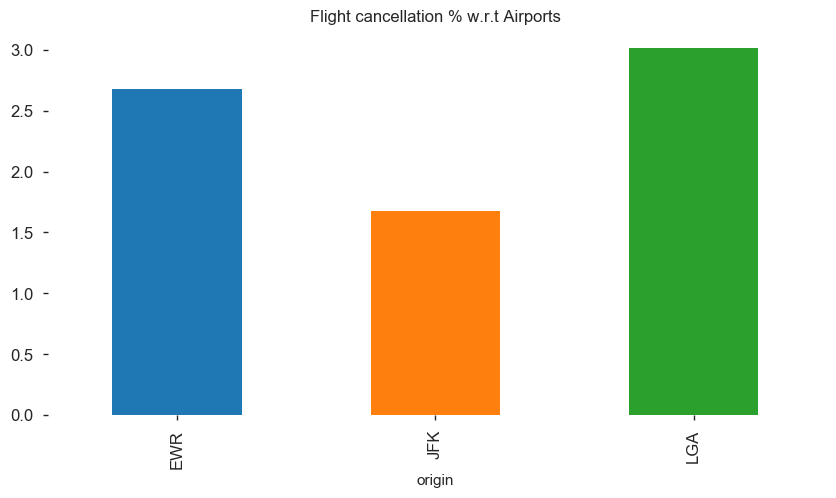

In [167]:
canAirPer['percentage'].plot(kind='bar', figsize=[10,5], title ="Flight cancellation % w.r.t Airports",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

### 3% of total flight got canceled LGA airport, which is highest among all.<br><br>

## 5.4.3 Best and worst carrier w.r.t total flight canceled

In [168]:
canCarrier = df.loc[df['dep_status'] == 'Canceled'].groupby(['carrier','dep_status'])['dep_status'].count().unstack('dep_status')
canCarrier

dep_status,Canceled
carrier,
9E,1044.0
AA,636.0
AS,2.0
B6,466.0
DL,349.0
EV,2817.0
F9,3.0
FL,73.0
MQ,1234.0


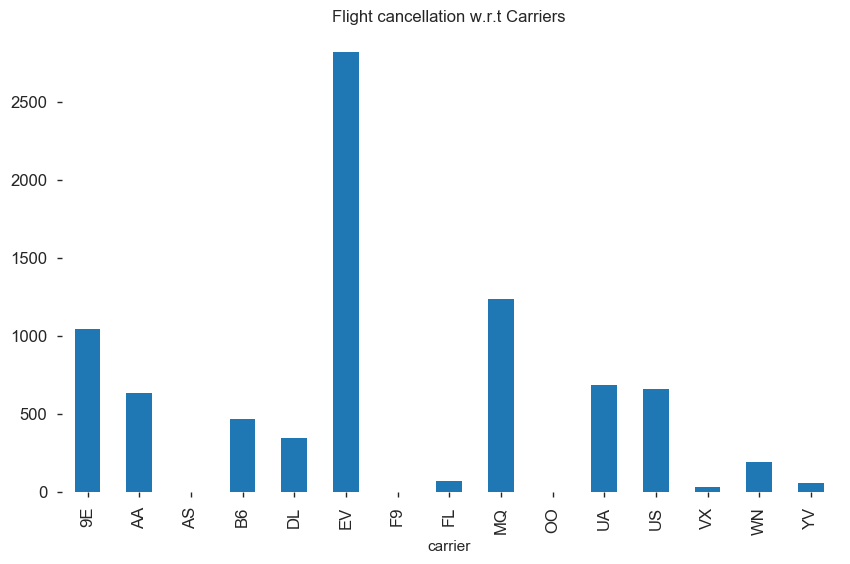

In [171]:
canCarrier.plot(kind='bar', figsize=[10,6], title ="Flight cancellation w.r.t Carriers",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

### AS, F9 and OO carriers are best in terms of flight cancellation.<br><br>

## 5.4.4 Flight cancellation across months

In [172]:
canMonth = df1.loc[df['dep_status'] == 'Canceled'].groupby(['month','dep_status'])['dep_status'].count().unstack('dep_status')
canMonth

dep_status,Canceled
month,
1,521.0
2,1261.0
3,861.0
4,668.0
5,563.0
6,1009.0
7,940.0
8,486.0
9,452.0


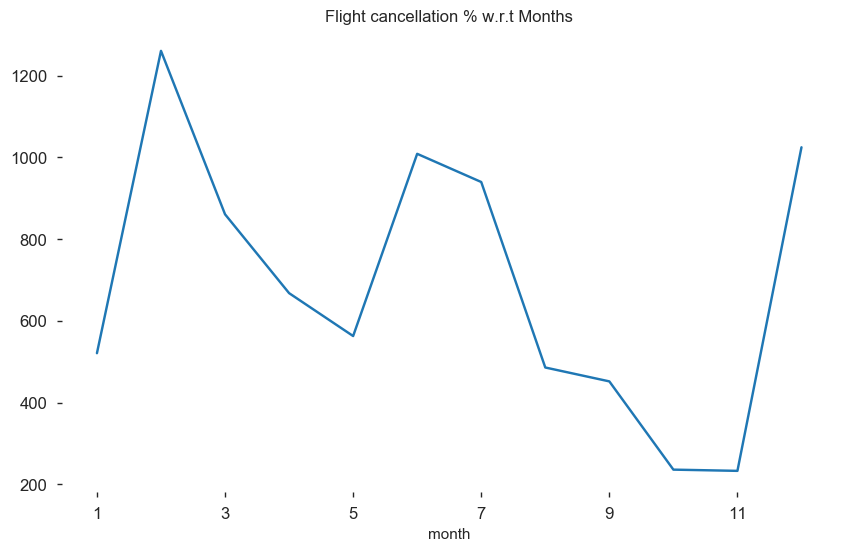

In [174]:
canMonth.plot(figsize=[10,6], title ="Flight cancellation % w.r.t Months",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

### Flight cancellation is lowest in October and November months

# 5.5 Flight speed
## 5.5.1 Fastest and slowest flight in 2013

In [176]:
df['speed'] = df['distance']/(df['air_time']/60)
print(df.iloc[df['speed'].idxmax()])
print(df.iloc[df['speed'].idxmin()])

month                           6
day                             1
dep_time          0 days 16:26:00
sched_dep_time    0 days 16:29:00
dep_delay                      -3
arr_time          0 days 18:50:00
sched_arr_time    0 days 18:53:00
arr_delay                      -3
carrier                        US
flight                         17
origin                        JFK
dest                          PHX
air_time                      144
distance                     2153
dep_status                 OnTime
arr_status                 OnTime
speed                     897.083
Name: 222734, dtype: object
month                           1
day                            13
dep_time          0 days 22:39:00
sched_dep_time    0 days 21:59:00
dep_delay                      40
arr_time          0 days 01:10:00
sched_arr_time    0 days 00:30:00
arr_delay                      40
carrier                        EV
flight                       4519
origin                        EWR
dest                

## 5.5.2 Average flight speed across all carriers

In [177]:
flightSpeed = df.groupby(['carrier'])['speed'].mean()
flightSpeed

carrier
9E    344.625846
AA    416.857053
AS    444.459187
B6    399.678786
DL    418.128015
EV    362.338709
F9    425.566706
FL    393.730749
HA    480.357719
MQ    367.912746
OO    366.320085
UA    420.799192
US    341.580788
VX    446.195066
WN    400.254407
YV    331.664615
Name: speed, dtype: float64

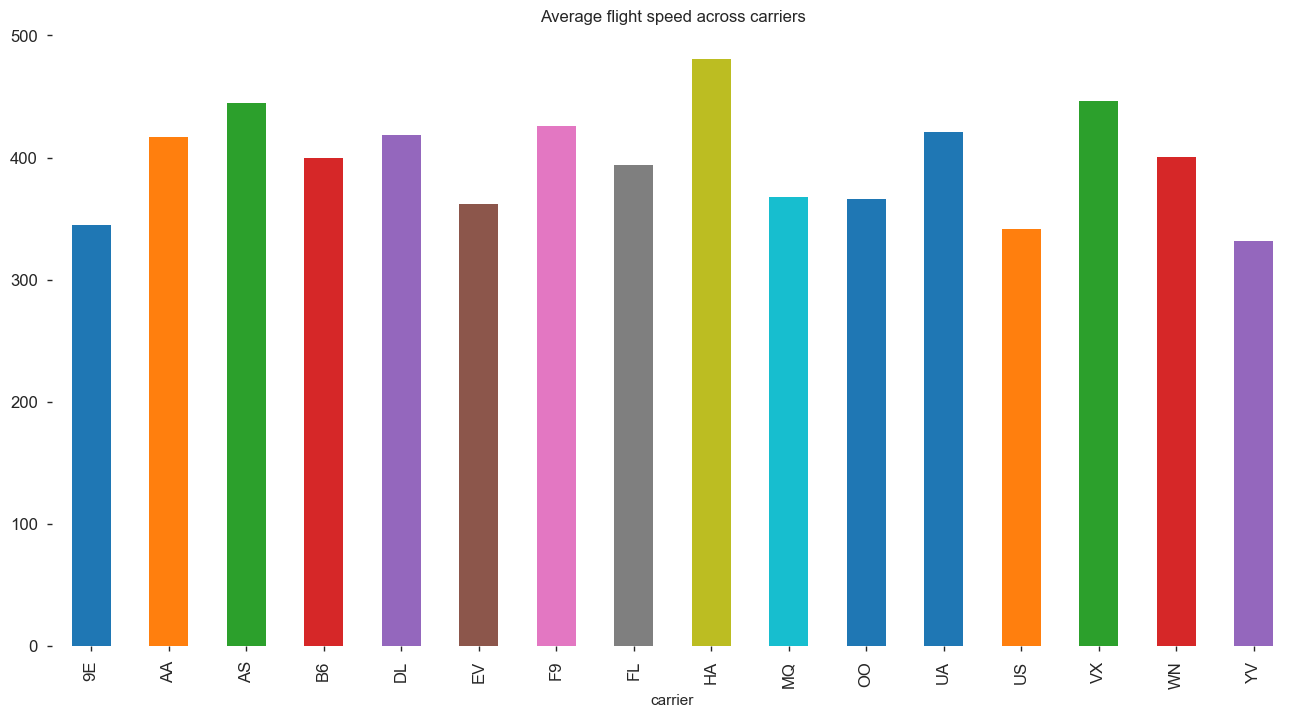

In [178]:
flightSpeed.plot(kind='bar', figsize=[16,8], title ="Average flight speed across carriers",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

### HA is best in terms of average flight speed with 480 miles/hr<br><br>

# 5.6 Conclusion


### In 2013, around 39% of flight got delayed and most of them were in June, July and December months. From flight frequency graph we can see that air traffic is more in these 3 months, So this is on the reason flights got delayed in June, July and December months.<br><br>

### Parveen Dala<br>+91 904 141 1410<br>dParveen94@gmail.com